### Prognozowanie i Symulacje
Maciej Odziemczyk, Karolina Stępień<br>
WNE UW

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
import time
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import spearmanr
from scipy.stats import wilcoxon

Generowanie danych według procesu

![](dgp_v2.png)

gdzie:<br>
&emsp; opady to opady deszczu l/m$^2$<br>
&emsp; zaciemnienie to jednostka ograniczenia widoczności (max - zerowa widoczność, min maksymalna widoczność)<br>
&emsp; prędkość to jednostka przekroczenia prędkości<br>
&emsp; niecierpliwość to miara niecierpliwości kierowcy<br>
&emsp; alkohol to miara skłonności kierowców do prowadzenia pojazdu pod wpływem alkoholu<br>
&emsp; niedzielni kierowcy to stosunek słabych kierowców do kierowców ogółem na drodze<br>
&emsp; $\varepsilon_{\dots}\sim N(0,1)$ to błędy losowe<br>
&emsp; a-f to parametry strukturalne procesu generującego dane

Analizowany poniżej przypadek to przypadek, w którym parametry a-c i e-i równe sa 1, a parametr d równy jest -1 

In [2]:
# ziarno losowe
np.random.seed(seed=2021)
# inicjacja data frame
df=pd.DataFrame()
# liczba obserwacji
N=1000000
# granica między próbą treningową a testową
stop=int(0.9*N)

# generowanie zmiennych
df["niecierpliwosc"]=np.random.normal(loc=0,scale=1,size=N)
df["alkohol"]=np.random.normal(loc=0,scale=1,size=N)
df["opady"]=np.random.normal(loc=0,scale=1,size=N)
df["zaciemnienie"]=df["opady"].values+np.random.normal(loc=0,scale=1,size=N)
df["niedzielni_kierowcy"]=-df["opady"].values+np.random.normal(loc=0,scale=1,size=N)
df["predkosc"]=df["alkohol"].values+df["niecierpliwosc"].values+np.random.normal(
    loc=0,scale=1,size=N)
df["wypadki"]=df["opady"].values+df["zaciemnienie"].values+df["predkosc"].values+df["alkohol"].values+\
df["niedzielni_kierowcy"].values+np.random.normal(loc=0,scale=1,size=N)

In [3]:
# ziarno losowe
np.random.seed(seed=2021)
# regresje liniowe
OLS_opady=smf.ols(formula="wypadki~opady",data=df.iloc[:stop,:]).fit()
OLS_opady_zaciemnienie=smf.ols(formula="wypadki~opady+zaciemnienie",data=df.iloc[:stop,:]).fit()
OLS_opady_kierowcy=smf.ols(formula="wypadki~opady+niedzielni_kierowcy", data=df.iloc[:stop,:]).fit()
# OLS_opady_predkosc_zacmienie=smf.ols(formula="wypadki~opady+zaciemnienie+predkosc", data=df.iloc[:stop,:]).fit()
OLS_opady_zaciemnienie_kierowcy=smf.ols(formula="wypadki~opady+zaciemnienie+niedzielni_kierowcy",
                                        data=df.iloc[:stop,:]).fit()
OLS_prawdziwy=smf.ols("wypadki~opady+zaciemnienie+predkosc+niedzielni_kierowcy",data=df.iloc[:stop,:]).fit()

# 2MNK - zmienna instrumentalna alkohol
aux=smf.ols(formula="predkosc~niecierpliwosc", data=df).fit()
aux_fitted=aux.fittedvalues.values
df["fitted"]=aux_fitted
OLS_prawdziwy_iv=smf.ols("wypadki~opady+zaciemnienie+niedzielni_kierowcy+fitted", data=df.iloc[:stop,:]).fit()

In [4]:
# wyniki regresji
strg=Stargazer(models=[OLS_opady, OLS_opady_zaciemnienie, OLS_opady_kierowcy,\
                       OLS_opady_zaciemnienie_kierowcy, OLS_prawdziwy, OLS_prawdziwy_iv])
strg.custom_columns(["opady", "opady_zaciemnienie", "opady_kierowcy",\
                     "ozk", "prawdziwy", "prawdziwy_iv"], [1,1,1,1,1,1])
strg.show_model_numbers(False)
strg

##### Analiza wyników regresji
 - uwzględniając jedynie opady, dopasowanie modelu jest bardzo niskie
 - uwzględniając opady i zaciemnienie, mediator którym dla opadów jest zaciemnienie ściąga ich efekt w kierunku zera, przez co opady stają się zmienną nieistotną, co jest nieprawdą
 - uwzględniając opady i drugiego mediatora tj. niedzielnych kierowców, opady obciążone są w drugą stronę - efekt jest przeszacowany. Zatem w przypadku, w którym zmienna posiada dwa mediatory i w modelu uwzględniony jest tylko jeden to obciążenie mediowanej zmiennej zależy od znaku z jakim przenoszony jest efekt przez pominiętego mediatora. Jeżeli pomijany jest mediator przenoszący ujemny efekt to efekt mediowanej zmiennej jest niedoszacowany, a w skrajnym przypadku równy zero tym samym nieistotny, zatem zastosowanie procedury od ogółu do szczegółu może skutkować usunięciem z modelu zmiennej, która w rzeczywistości jest zmienną istotną. Jeżeli pomijany jest mediator przenoszący dodatni efekt to efekt mediowanej zmiennej jest przeszacowany. 
 - uwzględniając mediatory i mediowane zmienne jeżeli zmienne mediowane mają również bezpośredni wpływ przyczynowy (wynikający z dgp) na zmienną objaśnianą, to estymatory są zgodne z parametrami strukturalnymi procesu generującego dane
 - pomimo zgnodności estymatorów modelu ozk jego dopasowanie do danych jest niskie ($R^2=0.3$), taki stan rzeczy wywołany jest pomnięciem istotnej zmiennej (prędkość)
 - zakładając, że zmienna alkohol jest nieobserwowalna, uwzględniając prędkość w modelu pojawia się problem równoczesności, tj. zmienna prędkość staje się zmienną endogeniczną i nie jest możliwe oszacowanie prawdziwego parametru (jeżeli wpływ zmiennej pominiętej na endogeniczną zmienną objaśniającą jest dodatni to parametr jest przeszacowany, jeżeli ujemny to jest niedoszacowany przy założeniu, że endogeniczna zmienna objaśniająca ma dodantni wpływ na zmienną objaśnianą)
 - model prawdziwy pomimo najlepszego dopasowania do danych oraz najniższego RMSE nie jest modelem, na podstawie którego można przeprowadzić poprawne wnioskowanie statystyczne z powodu obciążenia parametru zmiennej prędkość co wynika z problemu równoczesności będącego skutkiem pominięcia istotnej, nieobserwowalnej zmiennej (skorelowanej z prędkością i błędem z modelu - jeżeli w modelu pominięta jest zmienna to analitycznie trafia ona do epsilona, czyli reszty modelu)
 - problem równoczesności może zostać rozwiązany za pomocą zmiennych instrumentalnych. W przypadku rozważanego dgp instrumentem zmiennej prędkość jest zmienna niecierpliwość. Niecierpliwość jest poprawnym instrumentem, ponieważ nie jest skorelowana z błędem standardowym (pominięcie jej nie wpływa na zwiększenie reszt modelu, ponieważ nie ma ona bezpośredniego wpływu na zmienną objaśnianą), wpływa ona na endogeniczną zmienną objaśniającą prędkość i wpływ ten jest jednostronny (brak sprzężenia zwrotnego) oraz nie jest ona w żaden sposób powiązana z innymi zmiennymi objaśniającymi umieszczonymi w modelu
 - estymator 2MNK wykorzystany do zmiennej instrumentalnej niecierpliwość nie jest jednak estymatorem efektywnym (większe błędy standardowe oszacowań), ale uzyskane estymatory są zgodne - odzwierciedlają parametry strukturalne procesu generującego dane. Okazuje się jednak, że predykcje generowany przez model poprawny w kontekście wnioskowania statystycznego nie jest najlepszy pod kątem predykcji
 - wnioskuje się zatem o występowaniu sytuacji patowej i konieczności doboru modelu w zależności od potrzeb, w celu poprawnego wnioskowania statystycznego należy wybrać model prawdziwy_iv oszacowany przy wykorzystaniu Metody Zmiennej Instrumentalnych. W celu predykcji należy wybrać model prawdziwy oszacowany za pomocą MNK, którego oszacowania są obciążone (oszacowanie prędkości)
 
##### Testy diagnostyczne modeli
Testy pozwolą odpowiedzieć na pytanie czy standardowa diagnostyka modelu jest w stanie pomóc wybrać model poprawny z punktu wnioskowania statystycznego

In [5]:
# obiekt pomocniczy zawierający oszacowane modele
dct={"opady":OLS_opady,
     "opady_zaciemnienie":OLS_opady_zaciemnienie,
     "opady_kierowcy":OLS_opady_kierowcy,
#      "ols_opady_predkosc_zacmienie":OLS_opady_predkosc_zacmienie,
     "ols_opady_zaciemnienie_kierowcy":OLS_opady_zaciemnienie_kierowcy,
     "ols_prawdziwy":OLS_prawdziwy,
     "ols_prawdziwy_iv": OLS_prawdziwy_iv}

In [6]:
def RMSE(y, y_hat):
    '''
    funkcja zwracająca RMSE dla dwóch wektorów, argumenty
    y - wartości obserwowane
    y_hat - predykcje/wartości dopasowane
    
    return RMSE (skalar)
    '''
    return np.sqrt(1/len(y)*np.sum((y-y_hat)**2))

In [7]:
# ziarno losowe
np.random.seed(seed=2021)
# pętla diagnostyczna dla modeli
for i in dct.keys():
    # VIFy
    zmienne=dct[i].params.index.tolist()[1:]
    X_vif=df[zmienne].iloc[:stop,:]
    if len(zmienne)>1:
        vif = np.round([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])], 2)
        # przystosowanie wyników do wyświetlenia
        vif = list(map(float, vif))
        name = list(df[zmienne])
        s1 = pd.Series(name, name = 'Zmienna')
        s2 = pd.Series(vif, name = 'VIF')
        VIF_results = pd.concat([s1,s2], axis = 1)
    else:
        VIF_results= None
    
    # predykcje modelu
    y_hat=dct[i].predict(exog=df.iloc[stop:,:])
    # RMSE
    rmse=RMSE(df.wypadki.iloc[stop:],y_hat)
    # test RESET dla drugich potęg
    reset=linear_reset(dct[i],power=2, test_type="fitted") #test_type="princomp" dla HA: pca
    # kryterium informacyjne Akaike
    akaike=round(dct[i].aic)
    # kryterium informacyjne Bayesa-Schwartza
    bayes=round(dct[i].bic)
    # test Jarque-Bera na normalność reszt modelu
    jb=jarque_bera(dct[i].resid)[1]
    # test Breuscha-Pagana na heteroskedastyczność
    bp=het_breuschpagan(dct[i].resid, dct[i].model.exog)[1]
    # test Breuscha-Godfreya na autokorelację reszzt
    bg=acorr_breusch_godfrey(dct[i],2)[1]
    # druk wyników
    print("\n{} \n\tRESET: {}\n\tRMSE: {}\n\tAIC: {}\n\tBIC: {}\n\tJarque-Bera (p): {}\n\tBreusch-Pagan (p): {}\
    \n\tBreusch-Godfrey (p): {}".format(i, reset, rmse,akaike,bayes,jb,bp,bg))
    # druk statystyk VIF
    display(VIF_results)
    


opady 
	RESET: <Wald test (chi2): statistic=[[1.22444692]], p-value=0.268489703513036, df_denom=1>
	RMSE: 2.9999786412831053
	AIC: 4534815.0
	BIC: 4534839.0
	Jarque-Bera (p): 0.7783948182871723
	Breusch-Pagan (p): 0.9654857796212626    
	Breusch-Godfrey (p): 0.6168242526415129


None


opady_zaciemnienie 
	RESET: <Wald test (chi2): statistic=[[0.60212031]], p-value=0.43777017515506744, df_denom=1>
	RMSE: 2.8306512722170742
	AIC: 4427718.0
	BIC: 4427753.0
	Jarque-Bera (p): 0.6359661996329028
	Breusch-Pagan (p): 0.8654509935512613    
	Breusch-Godfrey (p): 0.6087952495584164


,Zmienna,VIF
0,opady,2.0
1,zaciemnienie,2.0



opady_kierowcy 
	RESET: <Wald test (chi2): statistic=[[1.23663059]], p-value=0.26612141135646256, df_denom=1>
	RMSE: 2.835410945168407
	AIC: 4428168.0
	BIC: 4428203.0
	Jarque-Bera (p): 0.3492564948039353
	Breusch-Pagan (p): 0.641178526906119    
	Breusch-Godfrey (p): 0.8062867797688512


,Zmienna,VIF
0,opady,2.0
1,niedzielni_kierowcy,2.0



ols_opady_zaciemnienie_kierowcy 
	RESET: <Wald test (chi2): statistic=[[0.00720866]], p-value=0.9323378361809532, df_denom=1>
	RMSE: 2.653388021321699
	AIC: 4307525.0
	BIC: 4307572.0
	Jarque-Bera (p): 0.8708426124487164
	Breusch-Pagan (p): 0.8757690791648028    
	Breusch-Godfrey (p): 0.5920276755857211


,Zmienna,VIF
0,opady,3.0
1,zaciemnienie,2.0
2,niedzielni_kierowcy,2.0



ols_prawdziwy 
	RESET: <Wald test (chi2): statistic=[[0.92694491]], p-value=0.3356580488069961, df_denom=1>
	RMSE: 1.2885961501058718
	AIC: 3015954.0
	BIC: 3016012.0
	Jarque-Bera (p): 0.8749721301640778
	Breusch-Pagan (p): 0.6979793576918292    
	Breusch-Godfrey (p): 0.5697342929862621


,Zmienna,VIF
0,opady,3.0
1,zaciemnienie,2.0
2,predkosc,1.0
3,niedzielni_kierowcy,2.0



ols_prawdziwy_iv 
	RESET: <Wald test (chi2): statistic=[[1.65101663]], p-value=0.19882061914379348, df_denom=1>
	RMSE: 2.4524781498637553
	AIC: 4168442.0
	BIC: 4168500.0
	Jarque-Bera (p): 0.9313304525631155
	Breusch-Pagan (p): 0.5094608814414685    
	Breusch-Godfrey (p): 0.9862329610224589


,Zmienna,VIF
0,opady,3.0
1,zaciemnienie,2.0
2,niedzielni_kierowcy,2.0
3,fitted,1.0


##### Analiza wyników diagnostyki
 - statystyki $VIF<5$ problem niedokładnej współliniowości nie występuje w żadnym modelu
 - testy Jarque-Bera, Breuscha-Pagana i Breuscha-Godfreya nie pozwalają na odrzucenie hipotezy zerowej na żadnym sensownym poziomie istotności, zatem wnioskuje sie o braku heteroskedastyczności, autokorelacji i normalności reszt dla każdego modelu
 - testy RESET nie pozwalają na odrzucenie hipotezy zerowej o poprawności (liniowości) formy funkcyjnej na żadnym sensownym poziomie istotności, zatem wnioskuje się o poprawnej (liniowej) formie funkcyjnej wszystkich modeli. Znając dgp przeprowadzenie RESETU nie ma sensu, bowiem rozważany przykład jest przykładem liniowym, szacując liniowe modele test RESET nie jest wartościowym narzędziem diagnostycznym, bowiem mówi on jedynie o liniowości dgp (które jest liniowe)
 - kreyteria informacyjne dają jednomyślny werdykt
 - Kryteria informacyjne za najlepszy wskazują model ze wszystkimi istotnymi zmiennymi, ale z obciążonym parametrem prędkości (bez MZI), drugim najlepszym modelem jest model zgodny (z MZI)
 - RMSE dla próby out of sample jest najniższe dla modelu z obciążonym parametrem (bez MZI), drugim najlepszym modelem jest model zgodny (z MZI)
 - modele prawdziwy i prawdziwy_iv są dwoma najlepszymi modelami pod każdym względem, ponadto model prawdziwy jest na jest modelem dużo lepszym od modelu prawdziwy_iv według przeprowadzonej diagnostyki. Oznacza, to że nie znając procesu generującego dane nie jest możliwe znalezienie prawdziwego modelu przy wykorzystaniu podstawowej diagnostyki, a znając proces generujący dane budowanie modelu nie ma sensu
 
##### Wykresy predykcji

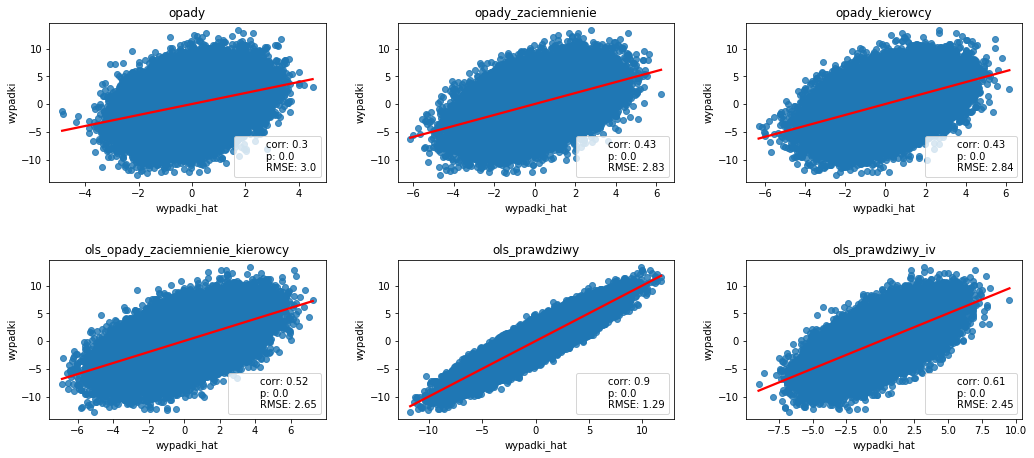

In [8]:
# ziarno losowe
np.random.seed(seed=2021)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,7))
ax=ax.flatten()
# wartości obserwowane
y=df.wypadki.iloc[stop:]
for i, model in enumerate(dct.keys()):
    # predykcje 
    y_hat=dct[model].predict(exog=df.iloc[stop:,:])
    # korelacja predykcji i wartości obserwowanych
    corr,p=np.round(spearmanr(y,y_hat),2)
    # RMSE
    rmse=round(RMSE(y,y_hat),2)
    # wykres
    sns.regplot(x=y_hat,y=y, line_kws={"color":"red"}, ax=ax[i], label="corr: {}\np: {}\nRMSE: {}".format(corr,p,rmse))
    ax[i].legend(markerscale=0,loc="lower right")
    ax[i].set_title(model)
    ax[i].set_xlabel("wypadki_hat")
    fig.tight_layout(pad=3.0)
plt.show()

Wnioski z wykresów są analogiczne do tych wyciągniętych na podstawie wyników regresji i testów diagnostycznych. Najlepszym pod kątem prognoz jest model prawdziwy (bez MZI), korelacja prognoz z wartościami obserwowanymi jest największa (0.9) i istotna (p=0). Drugim najelpszym modelem jest prawdziwy\_iv (z MZI), istotna korelacja 0.61. Z punktu widzenia prognoz nie ma znaczenia znak przenoszenia efektu przez pominiętego mediatora, modele opady\_zaciemnienie i opady\_kierowcy mają niemalże takie same wyniki. Najgorszy jest model uwzględniający tylko jedną zmienną, bez mediatorów i bez gałęzi ze zmienną pominiętą.

##### Symulacje uogólniające proces generujący dane
poniżej przeprowadzono symulację w celu zbadania rozkładów błędów prognoz mierzonych RMSE. Na podstawie powyższej analizy ustanawia się hipotezę:

$$Mediana(RMSE_{prawdziwy})<Mediana(RMSE_{prawdziwy\_iv})$$

1. Hipoteza przetestowana została za pomocą nieparametrycznego testu Wilcoxona na równość median.

2. Symulacja polega na losowaniu ze zwracaniem parametrów strukturalnych procesu generującego dane. Dla ułatwienia rozważanymi parametrami są jedynie liczby całkowite (uwzględnienie liczb rzeczywistych nie powinno zmienić wniosków, a jest dużo bardziej kosztowne obliczeniowo)

3. Ponieważ rozważany jest tylko przypadek ściągania efektu przyczynowego do zera przez mediator oraz przeszacowanie efektu endogenicznej zmiennej objaśniającej wynikającej z wystapienia problemu zmiennej pominiętej, na symulację narzucone zostały pewne ograniczenia:
 - $\{a,b,c,e,f,g,h,i\}\in\mathbb{Z}\cap\{1,2,\dots,10\}$ 
 - $d\in\mathbb{Z}\cap\{-10,-9,\dots,-1\}$

In [3]:
# ziarno losowe
np.random.seed(seed=2021)
# liczba obserwacji
N=1000000
# granica między próbą treningową a testową
stop=int(0.9*N)
# liczba losowań
l_los=1000
# losowa macierz parametrów strukturalnych procesu generującego dane
macierz_wag=np.random.randint(low=1,high=11,size=(l_los,9))
# słownik do zapisywania rmse
dct_rmse={"opady":[],
          "opady_zaciemnienie":[],
          "opady_kierowcy":[],
          "ols_opady_zaciemnienie_kierowcy":[],
          "ols_prawdziwy":[],
          "ols_prawdziwy_iv":[]}

start=time.time()
for wiersz in range(macierz_wag.shape[0]):
    # bieżące parametry strukturalne
    a,b,c,d,e,f,g,h,i=macierz_wag[wiersz,:]
    # inicjacja data frame
    df_sim=pd.DataFrame()
    # generowanie zmiennych
    df_sim["niecierpliwosc"]=np.random.normal(loc=0,scale=1,size=N)
    df_sim["alkohol"]=np.random.normal(loc=0,scale=1,size=N)
    df_sim["opady"]=np.random.normal(loc=0,scale=1,size=N)
    df_sim["zaciemnienie"]=a*df_sim["opady"].values+np.random.normal(loc=0,scale=1,size=N)
    df_sim["niedzielni_kierowcy"]=-d*df_sim["opady"].values+np.random.normal(loc=0,scale=1,size=N)
    df_sim["predkosc"]=h*df_sim["alkohol"].values+g*df_sim["niecierpliwosc"].values+np.random.normal(
        loc=0,scale=1,size=N)
    df_sim["wypadki"]=c*df_sim["opady"].values+b*df_sim["zaciemnienie"].values+f*df_sim["predkosc"].values+\
    i*df_sim["alkohol"].values+e*df_sim["niedzielni_kierowcy"].values+np.random.normal(loc=0,scale=1,size=N)
    
    # regresje liniowe
    OLS_opady=smf.ols(formula="wypadki~opady",data=df_sim.iloc[:stop,:]).fit()
    OLS_opady_zaciemnienie=smf.ols(formula="wypadki~opady+zaciemnienie",data=df_sim.iloc[:stop,:]).fit()
    OLS_opady_kierowcy=smf.ols(formula="wypadki~opady+niedzielni_kierowcy", data=df_sim.iloc[:stop,:]).fit()
    OLS_opady_zaciemnienie_kierowcy=smf.ols(formula="wypadki~opady+zaciemnienie+niedzielni_kierowcy",
                                            data=df_sim.iloc[:stop,:]).fit()
    OLS_prawdziwy=smf.ols("wypadki~opady+zaciemnienie+predkosc+niedzielni_kierowcy",data=df_sim.iloc[:stop,:]).fit()
    # 2MNK - zmienna instrumentalna alkohol
    aux=smf.ols(formula="predkosc~niecierpliwosc", data=df_sim).fit()
    aux_fitted=aux.fittedvalues.values
    df_sim["fitted"]=aux_fitted
    OLS_prawdziwy_iv=smf.ols("wypadki~opady+zaciemnienie+niedzielni_kierowcy+fitted", data=df_sim.iloc[:stop,:]).fit()
    
    # zapis predykcji
    y=df_sim.wypadki.iloc[stop:]
    dct_rmse["opady"].append(RMSE(y,OLS_opady.predict(exog=df_sim.iloc[stop:,:])))
    dct_rmse["opady_zaciemnienie"].append(RMSE(y,OLS_opady_zaciemnienie.predict(exog=df_sim.iloc[stop:,:])))
    dct_rmse["opady_kierowcy"].append(RMSE(y,OLS_opady_kierowcy.predict(exog=df_sim.iloc[stop:,:])))
    dct_rmse["opady_zaciemnienie_kierowcy"].append(RMSE(y, OLS_opady_zaciemnienie_kierowcy.predict(
        exog=df_sim.iloc[stop:,:])))
    dct_rmse["prawdziwy"].append(RMSE(y,OLS_prawdziwy.predict(exog=df_sim.iloc[stop:,:])))
    dct_rmse["prawdziwy_iv"].append(RMSE(y,OLS_prawdziwy_iv.predict(exog=df_sim.iloc[stop:,:])))

# finalny dataframe z wynikami
wyniki=pd.concat(
    (pd.DataFrame(macierz_wag, columns=["a","b","c","d","e","f","g","h","i"]), pd.DataFrame(dct_rmse)),
    axis=1)
# informacja o czasie trwania symulacji
stop=time.time()
print("czas trwania symulacji: {}s".format(round(stop-start,2)))

czas trwania symulacji: 2326.32s


In [4]:
# # zapis wyników do pliku csv
# wyniki.to_csv("wyniki_symulacji.csv")

In [9]:
# wczytanie wyników z pliku csv
wyniki=pd.read_csv(r"wyniki_symulacji.csv",index_col=0)

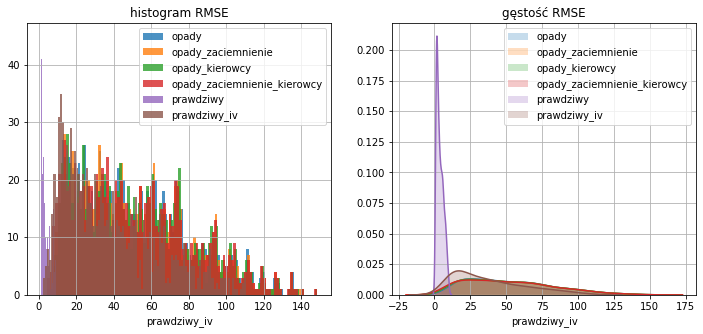

In [10]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,5))
for model in wyniki.columns.tolist()[9:]:
    sns.distplot(wyniki.loc[:,model], hist=True, kde=False, hist_kws={"alpha":0.8}, ax=ax[0], bins=100)
    sns.distplot(wyniki.loc[:,model], hist=False, kde=True, kde_kws={"shade":True}, ax=ax[1])
    ax[0].grid(True)
    ax[1].grid(True)
    ax[0].legend(wyniki.columns.tolist()[9:])
    ax[1].legend(wyniki.columns.tolist()[9:])
    ax[0].set_title("histogram RMSE")
    ax[1].set_title("gęstość RMSE")
plt.show()

Ewidentnie najbardziej skupiony wokół zera jest rozkład $RMSE_{ols\_prawdziwy}$ reszta rozkładów jest dość podobna, jednak rozkład $RMSE_{ols\_prawdziwy\_iv}$ charakteryzuje się widoczną dominantą bliżej zera od pozostałych. Poniżej histogramy i gęstości rozkładów RMSE z pominięciem modelu $ols_{prawdziwy}$

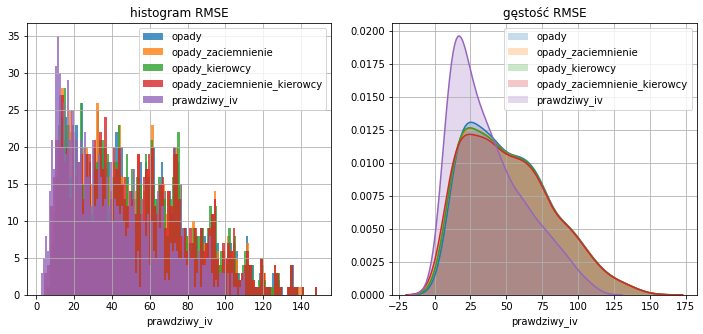

In [11]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,5))
modele=["opady","opady_zaciemnienie","opady_kierowcy","opady_zaciemnienie_kierowcy","prawdziwy_iv"]
for model in modele:
    sns.distplot(wyniki.loc[:,model], hist=True, kde=False, hist_kws={"alpha":0.8}, ax=ax[0], bins=100)
    sns.distplot(wyniki.loc[:,model], hist=False, kde=True, kde_kws={"shade":True}, ax=ax[1])
    ax[0].grid(True)
    ax[1].grid(True)
    ax[0].legend(modele)
    ax[1].legend(modele)
    ax[0].set_title("histogram RMSE")
    ax[1].set_title("gęstość RMSE")
plt.show()

Po analizie wykresów można się zatem spodziewać braku statystycznych różnic między medianami RMSE modeli $ols_{opady\_zaciemnienie}$ i $ols_{opady\_kierowcy}$ różnymi od nich medianami RMSE $ols_{opady\_zaciemnienie\_kierowcy}$ i $ols\_opady$, niższą dla RMSE modelu $ols_{prawdziwy\_iv}$ oraz najniższą średnią RMSE dla modelu $ols_{prawdziwy}$
##### Test Wilcoxona na równość median
Test Wilcoxona jest testem nieparametrycznym niewymagającym założeń o równej wariancji porównywanych prób

In [12]:
print("p value dla H0: mediana(RMSE_opady_zaciemnienie)=mediana(RMSE_opady_kierowcy):",
      wilcoxon(wyniki.opady_zaciemnienie,wyniki.opady_kierowcy,alternative="two-sided")[1])
print("p value dla H0: mediana(RMSE_opady)>mediana(RMSE_opady_zaciemnienie):",
      wilcoxon(wyniki.opady,wyniki.opady_zaciemnienie,alternative="greater")[1])
print("p value dla H0: mediana(RMSE_opady_zaciemnienie)>mediana(RMSE_opady_zaciemnienie_kierowcy):",
     wilcoxon(wyniki.opady_zaciemnienie,wyniki.opady_zaciemnienie_kierowcy, alternative="greater")[1])
print("p value dla H0: mediana(RMSE_opady_zaciemnienie_kierowcy)>mediana(RMSE_prawdziwy_iv):",
     wilcoxon(wyniki.opady_zaciemnienie_kierowcy, wyniki.prawdziwy_iv, alternative="greater")[1])
print("p value dla H0: mediana(RMSE_prawdziwy_iv)>mediana(RMSE_prawdziwy):",
     wilcoxon(wyniki.prawdziwy_iv,wyniki.prawdziwy,alternative="greater")[1])

p value dla H0: mediana(RMSE_opady_zaciemnienie)=mediana(RMSE_opady_kierowcy): 0.35243154062231763
p value dla H0: mediana(RMSE_opady)>mediana(RMSE_opady_zaciemnienie): 1.6729454079174543e-165
p value dla H0: mediana(RMSE_opady_zaciemnienie)>mediana(RMSE_opady_zaciemnienie_kierowcy): 1.6629295594672565e-165
p value dla H0: mediana(RMSE_opady_zaciemnienie_kierowcy)>mediana(RMSE_prawdziwy_iv): 1.6629295594672565e-165
p value dla H0: mediana(RMSE_prawdziwy_iv)>mediana(RMSE_prawdziwy): 1.6629295594672565e-165


Okazuje się, że przypuszczenia okazały się prawdziwe i na podstawie testów Wilcoxona można stwierdzić, że nierówność dla median analizowanych rozkładów RMSE dla poszczególnych modeli prezentuje się następująco:

$$opady>opady\_zaciemnienie>opady\_zaciemnienie\_kierowcy>prawdziwy\_iv>prawdziwy$$

oraz

$$opady\_zaciemnienie=opady\_kierowcy$$

Ponadto przykład zaprezentowany jako główny okazał się dobrą reprezentacją całego eksperymentu odpowiednio wskazując znaki kierunki nierówności, a ranking modeli predykcyjnych prezentuje się następująco:
1. model ze wszystkimi zmiennymi i obciążeniem wynikającym z problemu równoczesności
2. model nieobciążony
3. model z pominięciem gałęzi, w której występuje równoczesność spowodowana zmienną pominiętą
4. obciążony model z pominięciem mediatora dodatnio przenoszącego wpływ oraz obciążony model z pominięciem mediatora ujemnie przenoszącego wpływ
6. model tylko z mediowaną zmienną, nieobciążony co do parametru

Wnioskuje się również o występowaniu trade-offu pomiędzy predykcją a wnioskowaniem statystycznym